In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd

In [35]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [37]:
# create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [38]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [39]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [40]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [62]:
# find column names for measurement table
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


2017-08-23
Query Dates are days between 2016-08-23 and 2017-08-23.


/Users/staceywai/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


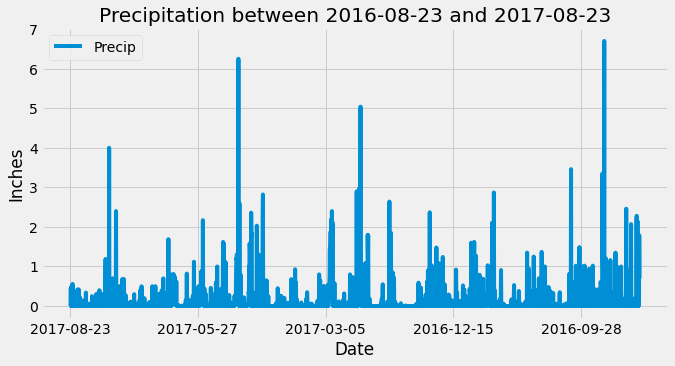

In [108]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# last date
LastDate = engine.execute("SELECT MAX(date) FROM Measurement").first()
print(LastDate[0])
LastDate=LastDate[0]
type(LastDate)

Year = int(LastDate[0:4])
Month = int(LastDate[5:7])
Day = int(LastDate[8:])


FirstDate = dt.date(Year,Month,Day)-dt.timedelta(days=365)
print(f'Query Dates are days between {FirstDate} and {LastDate}.')

# # Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date,Measurement.prcp)\
            .filter(Measurement.date >= FirstDate)\
            .filter(Measurement.date <= LastDate)\
            .order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data).rename(columns ={'date':'Date','prcp':'Precip'})
prcp_df.set_index('Date', inplace=True)
prcp_df['Precip'] = prcp_df['Precip'].fillna(0)
prcp_df

# Sort the dataframe by date
prcp_df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(10,5),title=f'Precipitation between {FirstDate} and {LastDate}',label='Precipitation')
plt.ylabel('Inches')
plt.xlabel('Date')
plt.show()

In [93]:
# Use Pandas to calcualte the summary statistics for the precipitation data
round(prcp_df.describe(),2)

,Precip
count,2230.00
mean,0.16
std,0.44
min,0.00
25%,0.00
50%,0.01
75%,0.11
max,6.70


In [117]:
# Design a query to show how many stations are available in this dataset?
# find column names for station table
inspector = inspect(engine)

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])
    
# query to count stations    
stations = session.query(Station).count()
print(f'The total number of stations is {stations}.')

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
The total number of stations is 9.


In [139]:
# What are the most active stations? (i.e. what stations have the most rows)?

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station)\
                .order_by(func.count(Measurement.station).desc()).all()

active_stations

# List the stations and the counts in descending order.
active_stations_df = pd.DataFrame(active_stations,columns=['Station ID','Observation Count'])
active_stations_df


,Station ID,Observation Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [154]:
# def most active station
most_active = active_stations_df.max()
most_active_ID = most_active[0]
print(f'The most active station is Station', most_active_ID)

The most active station was Station USC00519523


In [200]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Query the last 12 months of temperature observation data for this station
active_station_temps = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
            .filter(Measurement.station == most_active_ID)\
            .filter(Measurement.date >= FirstDate)\
            .filter(Measurement.date <= LastDate)

# store temps in variables
min_temp = round(active_station_temps[0][0],2)
max_temp = round(active_station_temps[0][1],2)
ave_temp = round(active_station_temps[0][2],2)  

# print results
print(f'\n',
        'The most active station is Station', most_active_ID,'.','\n',
        'For the last 12 months:','\n',
         'The average temperature was:', ave_temp,'\n',
         'The lowest temperature was:',min_temp,'\n',
         'The highest temperature was:',ave_temp)



 The most active station is Station USC00519523 . 
 For the last 12 months: 
 The average temperature was: 76.97 
 The lowest temperature was: 60.0 
 The highest temperature was: 76.97


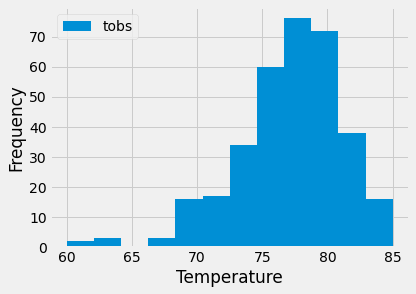

In [153]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_data = session.query(Measurement.tobs)\
            .filter(Measurement.station == most_active_ID)\
            .filter(Measurement.date >= FirstDate)\
            .filter(Measurement.date <= LastDate)

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(active_station_data, columns=['tobs'])
df

# Plot histogram
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel('Temperature')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
